# Electron Photon tagging

This is a first test to implement a QAE and compare it to a classical AE.  
The task is to identify Electrons and Photons from em-calorimeter images.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import tensorflow as tf
import tensorflow_quantum as tfq
from hep_VQAE import data_preprocessing as dp
from hep_VQAE import CAE as cae
from tensorflow.keras import layers, losses

import warnings
warnings.filterwarnings('ignore')

2022-07-05 23:22:20.502569: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-05 23:22:20.502588: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-07-05 23:22:21.485293: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-05 23:22:21.485314: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-05 23:22:21.485329: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tomskopfbahnhof): /proc/driver/nvidia/version does not exist
2022-07-05 23:22:21.485551: I tensorflow/core/platform/cpu_fe

In [2]:
data = np.load('../../data/electron-photon.npz', allow_pickle=True)

x_train = data['x_train']
x_test = data['x_test']
y_train = data['y_train']
y_test = data['y_test']

maxx = np.max(x_train)
minn = np.min(x_train)

x_train = x_train / maxx
x_test = x_test / maxx

print("x_train: ", x_train.shape)
print("x_test: ", x_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

x_train:  (100, 32, 32)
x_test:  (100, 32, 32)
y_train:  (100,)
y_test:  (100,)


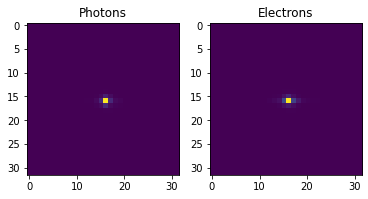

In [3]:
fig, axs = plt.subplots(1,2)

axs[0].imshow(np.average(x_train[y_train==0],0))
axs[0].title.set_text('Photons')

axs[1].imshow(np.average(x_train[y_train==1],0))
axs[1].title.set_text('Electrons')

In [6]:
latent_dim = 2
ae = cae.VAE()

In [7]:
ae.compile(optimizer=tf.keras.optimizers.Adam())

In [9]:
x_train_e = x_train[y_train==1]
x_train = x_train[y_train==0]

x_test_e = x_test[y_test==1]
x_test = x_test[y_test==0]

In [11]:
x_train = x_train.reshape(x_train.shape + (1,))

In [12]:
x_train.shape

(44, 32, 32, 1)

In [13]:
#es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
hist = ae.fit(x_train,
                epochs=300,
                shuffle=True)
                #validation_data=x_test,
                #callbacks=[es])

Epoch 1/300
2/2 [==============================] - 1s 19ms/step - loss: 707.9454 - reconstruction_loss: 707.4163 - kl_loss: 1.0777e-04
Epoch 2/300
2/2 [==============================] - 0s 10ms/step - loss: 701.1704 - reconstruction_loss: 700.6455 - kl_loss: 0.0026
Epoch 3/300
2/2 [==============================] - 0s 13ms/step - loss: 689.1869 - reconstruction_loss: 687.9010 - kl_loss: 0.0177
Epoch 4/300
2/2 [==============================] - 0s 12ms/step - loss: 670.1516 - reconstruction_loss: 668.4984 - kl_loss: 0.0815
Epoch 5/300
2/2 [==============================] - 0s 8ms/step - loss: 634.1985 - reconstruction_loss: 629.4333 - kl_loss: 0.3225
Epoch 6/300
2/2 [==============================] - 0s 13ms/step - loss: 590.0011 - reconstruction_loss: 586.7086 - kl_loss: 1.0965
Epoch 7/300
2/2 [==============================] - 0s 9ms/step - loss: 467.3236 - reconstruction_loss: 445.5913 - kl_loss: 3.8720
Epoch 8/300
2/2 [==============================] - 0s 8ms/step - loss: 335.2711 -

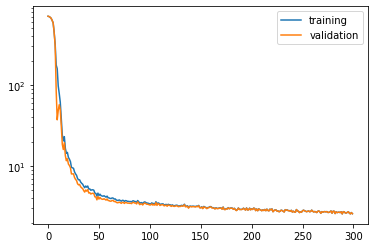

In [14]:
plt.plot(hist.history['loss'], label="training")
plt.plot(hist.history['reconstruction_loss'], label="validation")
plt.yscale('log')
plt.legend()

In [24]:
def mae(x):
    pred = ae.predict(x)
    return np.mean(np.abs(x - pred)**2,axis=(1,2,3))

def recon_acc(x):
    return 1 - mae(x)

def IF(x):
    pred = ae.predict(x)
    return 1 - np.sum((x - pred)**2,axis=(1,2))/np.sum(x*pred,axis=(1,2))
def IF2(x):
    pred = ae.predict(x)
    return 1 - np.sum((x - pred)**2,axis=(1,2))/np.sum(x**2,axis=(1,2))

In [25]:
photons = recon_acc(x_test.reshape(x_test.shape + (1,)))
electrons = recon_acc(x_test_e.reshape(x_test_e.shape + (1,)))

0.99995166
0.99996233


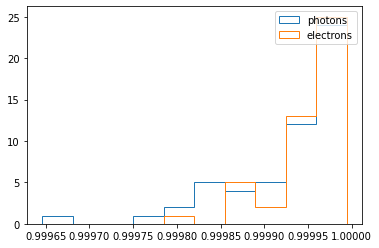

In [26]:
print(np.median(photons))
bins = np.histogram(np.hstack((photons, electrons)), bins=10)[1]
plt.hist(photons, histtype='step', label="photons",bins=bins)#,bins=[0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.0011,0.0012,0.0013])
print(np.median(electrons))
plt.hist(electrons, histtype='step', label="electrons",bins=bins)#,bins=[0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.0011,0.0012,0.0013])
plt.legend()

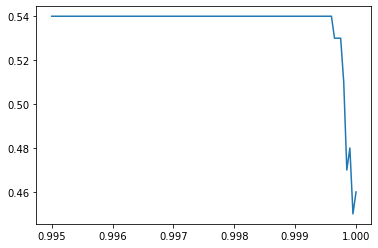

In [27]:
def acc_for_threshold(T):
    # sixes that are predicted photon
    num_six_right = np.sum(photons > T)
    # threes that are predicted three
    num_three_right = np.sum(electrons < T)
   
    acc = (num_six_right + num_three_right)/(len(photons) + len(electrons))
    return acc

Ts = np.linspace(0.995,1,100)
accs = []
for i in Ts:
    accs.append(acc_for_threshold(i))
plt.plot(Ts, accs) 

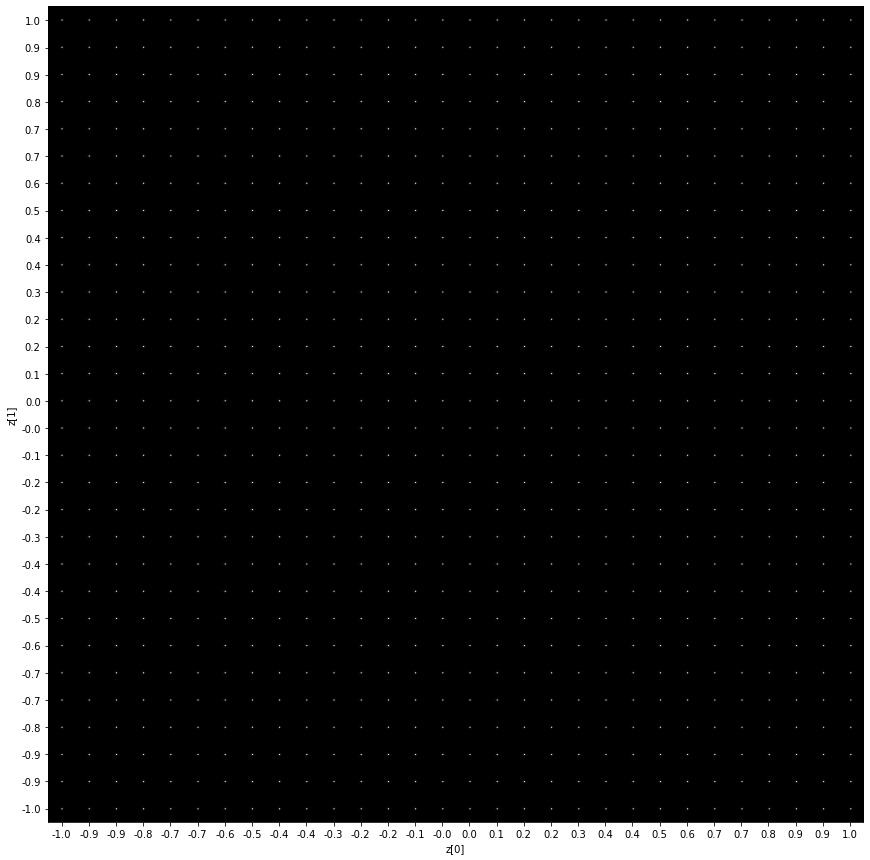

In [30]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 32
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(ae)